In [2]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import random
import time
from glob import glob

In [50]:
def data_gap_format(data):
    hight_pitch, low_pitch, gap = 0, 0, 0

    for i in data:
        if i > hight_pitch and i > 0:
            hight_pitch = i
        if i < low_pitch and i < 0:
            low_pitch = i

    gap = hight_pitch if hight_pitch > (low_pitch * -1) else (low_pitch * -1)

    return hight_pitch, low_pitch, gap, [i / gap for i in data]

def data_gap_resize(data, gap):
    return [i * gap for i in data]

def data_encoder(data, gap):
    reshape_len = len(data)
    
    format_data = np.array([[0, 128 / gap, 0] if i == 0 else [i, 0, 0] if i > 0 else [0, 0, i * -1] for i in data])
    
    return format_data.reshape(reshape_len * 3)

def data_decoder(data):
    data = np.array(data).tolist()
    reshape_len = len(data)
    
    not_enough = reshape_len % 3
    to_enough = (3 - not_enough)
    
    if to_enough is not 0:
        reshape_len += to_enough
    
    for i in range(to_enough):
        data.append(0)
    
    decode_data = []
    data = np.array(data).reshape((int(reshape_len / 3), 3))
    
    for i in data:
        value = np.amax(i)
        index = list(i).index(value)
        
        if index == 0:
            pass
        elif index == 1:
            value = 0
        else:
            value = value * -1
            
        decode_data.append(value)
    
    return decode_data

# data drop

def drop_data(dataset):
    return [dataset[i] for i in range(0, len(dataset), 4)]

def data_traing(dataset, index):
    return dataset[index - int(image_dim / 3) : index]

In [45]:
data_decoder(np.array([1, 0, 10, 1]))

[-10, 1]

In [4]:
# data load

# wave_files = glob("kevin_wave/*.wav")

# x_wave = []

# for index, file in enumerate(wave_files):
#     _, contents = wavfile.read(file)

#     x_wave = x_wave + [i[0] for i in contents]
    
# hight_pitch, low_pitch, gap, x_wave = data_gap_format(x_wave)

In [5]:
# np.array(x_wave).shape

In [6]:
# x_wave = np.array(x_wave)
# np.save("gan_64_x_tmp_save.npy", x_wave)

In [23]:
# x_wave_encode = data_encoder(x_wave, gap)
# np.save("gan_64_3_x_tmp_save.npy", x_wave_encode)

In [46]:
# load default data

hight_pitch, low_pitch, gap = 24811, -26038, 26038

x_wave = np.load("gan_64_x_tmp_save.npy")
x_wave = x_wave.tolist()

In [47]:
# network setting

z_dim = 180
image_dim = z_dim * 4
image_dim_zip = z_dim * 2


total_samples = len(x_wave)

In [48]:
# np.array(np.array(data_traing(x_wave_encode, 999)) * gap).reshape((int(image_dim/3), 3))

In [51]:
X = []
Y = []
auto_save_time = 10
last_time_save = time.time()

for i in range(len(x_wave)):
    this_data = data_traing(x_wave, i)
    
    if (np.all(np.array(this_data)==0)):
        continue
    
    Y.append(data_decoder(this_data))
    X.append(data_decoder(drop_data(this_data)))
    
    if len(X) > 1000:
        break

In [57]:
len(X)

1001

len(x_wave)

In [8]:
np.array(x_wave).shape

(25781124,)

In [9]:
hight_pitch

24811

In [10]:
low_pitch

-26038

In [11]:
gap

26038

In [12]:
np.all(np.zeros(10)==0)

True

In [13]:
np.zeros(10)==0

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [14]:
np.all(np.array([0,0,0,0])==0)

True

In [15]:
np.all(np.array([0,1,0,0])==0)

False

In [16]:
np.all([0,0,0,0]==0)

False

In [17]:
np.all(np.array([])==0)

True

In [20]:
# test data_traing function

data_traing(x_wave, 882) == [x_wave[i] for i in range(882)]

False

In [21]:
# test drop_data function

test_drop_traing_data = data_traing(x_wave, image_dim)

test_drop = drop_data(test_drop_traing_data)

print (len(test_drop) == z_dim)

print (test_drop[0] == test_drop_traing_data[0])

print (test_drop[1] == test_drop_traing_data[3])

print (not test_drop[1] == test_drop_traing_data[2])

True
True
True
True


In [22]:
import tensorflow as tf
import tflearn

In [23]:
# Generator
def generator(x, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        x = tflearn.fully_connected(x, image_dim_zip, activation='relu')
        x = tflearn.fully_connected(x, image_dim, activation='sigmoid')
        return x


# Discriminator
def discriminator(x, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        x = tflearn.fully_connected(x, image_dim_zip, activation='relu')
        x = tflearn.fully_connected(x, 1, activation='sigmoid')
        return x

In [24]:
gen_input = tflearn.input_data(shape=[None, z_dim], name='input_noise')
disc_input = tflearn.input_data(shape=[None, image_dim], name='disc_input')

gen_sample = generator(gen_input)
disc_real = discriminator(disc_input)
disc_fake = discriminator(gen_sample, reuse=True)

# Define Loss
disc_loss = -tf.reduce_mean(tf.log(disc_real) + tf.log(1. - disc_fake))
gen_loss = -tf.reduce_mean(tf.log(disc_fake))

gen_vars = tflearn.get_layer_variables_by_scope('Generator')
gen_model = tflearn.regression(gen_sample, placeholder=None, optimizer='adam',
                               loss=gen_loss, trainable_vars=gen_vars,
                               batch_size=64, name='target_gen', op_name='GEN')
disc_vars = tflearn.get_layer_variables_by_scope('Discriminator')
disc_model = tflearn.regression(disc_real, placeholder=None, optimizer='adam',
                                loss=disc_loss, trainable_vars=disc_vars,
                                batch_size=64, name='target_disc', op_name='DISC')

gan = tflearn.DNN(gen_model)

In [25]:
X = []
Y = []
auto_save_time = 10
last_time_save = time.time()

for i in range(len(x_wave_encode)):
    this_data = data_traing(x_wave_encode, i)
    
    if (np.all(np.array(this_data)==0)):
        continue
    
    Y.append(this_data)
    X.append(drop_data(this_data))
    
    if len(X) > 1000:
        gan.fit(X_inputs={gen_input: X, disc_input: Y}, Y_targets=None, n_epoch=100)
        X = []
        Y = []
        
    if (last_time_save + (60 * auto_save_time)) < time.time():
        last_time_save = time.time()
        gan.save("tmp_gan_64_save")
        
        print("auto save")
        
        # test code
        break

Training Step: 107199  | total loss: nan | time: 0.069s
| GEN | epoch: 6700 | loss: nan -- iter: 0960/1001
| DISC | epoch: 6700 | loss: 1.38629 -- iter: 0960/1001
Training Step: 107200  | total loss: nan | time: 0.074s
| GEN | epoch: 6700 | loss: nan -- iter: 1001/1001
| DISC | epoch: 6700 | loss: 1.38629 -- iter: 1001/1001
--
INFO:tensorflow:/home/lewis/wave_test/tmp_gan_64_save is not in all_model_checkpoint_paths. Manually adding it.
auto save


In [26]:
gan.save("tmp_gan_64_save")

INFO:tensorflow:/home/lewis/wave_test/tmp_gan_64_save is not in all_model_checkpoint_paths. Manually adding it.


In [27]:
gan.load("tmp_gan_64_save")

INFO:tensorflow:Restoring parameters from /home/lewis/wave_test/tmp_gan_64_save


In [28]:
test_predict_y = data_traing(x_wave_encode, 88888)
test_predict_x = drop_data(test_predict_y)

# test_predict_x_view = np.array([[i, 0, 0, 0] for i in test_predict_x]).reshape(len(test_predict_x * 4))

In [29]:
test_predict_x = np.array(test_predict_x)
print(test_predict_x.shape)
print(np.array([test_predict_x]).shape)

(180,)
(1, 180)


In [30]:
gan_predict = gan.predict([[test_predict_x]])

In [31]:
predict_decode = gan_predict

In [32]:
predict_decode

array([[ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan, 

In [33]:
# plt.figure(1)
# plt.title('wave_input')
# plt.plot(test_predict_x_view)
# plt.show()

plt.figure(1)
plt.title('wave_predict')
plt.plot(data_decoder(predict_decode))
plt.show()

plt.figure(1)
plt.title('wave_real')
plt.plot(data_decoder(test_predict_y))
plt.show()

TypeError: unorderable types: list() >= int()

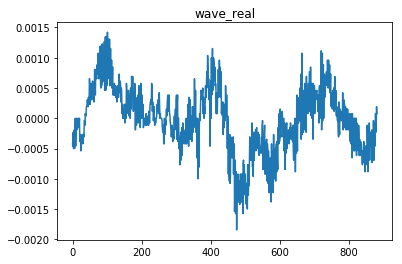

In [ ]:
plt.figure(1)
plt.title('wave_data_predict')
plt.plot(gan_predict[0])
plt.show()

In [ ]:
test_real_data = pick_wave_data(x_wave, 88888)

tmp = np.array([int_to_matrix(i, gap) for i in test_real_data]).reshape(y_size)

tmp_x = pick_x_data(np.array(tmp, copy=True))

gan_predict = gan.predict([[tmp_x]])

In [ ]:
plt.figure(1)
plt.title('wave_predict')
plt.plot([matrix_to_int(i) for i in gan_predict[0]])
plt.show()

plt.figure(1)
plt.title('wave_real')
plt.plot(test_real_data)
plt.show()